In [2]:
from skimage import io
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA
from skimage.transform import SimilarityTransform
from skimage.transform import warp
import os
import pathlib


In [3]:
import filters.filters as f
import image_load_and_converttion.load as l
import Analyse as a

In [4]:
#read a landmarkk file
def read_landmark_file(file_name):
    f = open(file_name, 'r')
    lm_s = f.readline().strip().split(' ')
    n_lms = int(lm_s[0])
    if n_lms < 3:
        print(f"Not enough landmarks found")
        return None

    new_lms = 3
    # 3 landmarks each with (x,y)
    lm = np.zeros((new_lms, 2))
    for i in range(new_lms):
        lm[i, 0] = lm_s[1 + i * 2]
        lm[i, 1] = lm_s[2 + i * 2]
    return lm

In [8]:
#exampel of reading a lanmark file
landmark1="../data/data4/00000001_000.jpg.cat"
lm1=read_landmark_file(landmark1)

lm_dis="../data/data4/ModelCat.jpg.cat"
lm_dis=read_landmark_file(lm_dis)


Shape of image is (500, 375, 3)
 data uint8


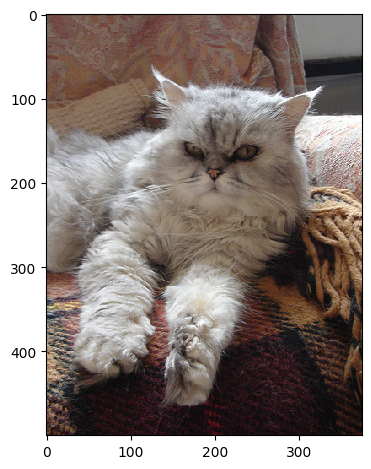

Shape of image is (474, 500, 3)
 data uint8


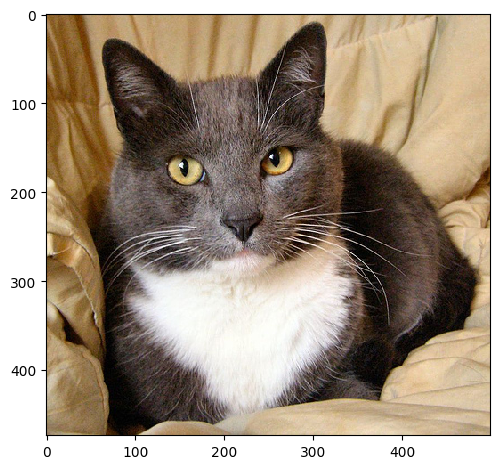

In [9]:
src1="../data/data4/00000001_000.jpg"
src1_im=l.load_im(src1)


dis="../data/data4/ModelCat.jpg"
dis_im=l.load_im(dis)


In [20]:
#using landmark based registration with a similarity transform and Crop the registered photo
def align_and_crop_one_cat_to_destination_cat(img_src, lm_src, img_dst, lm_dst):
    """
    Landmark based alignment of one cat image to a destination
    :param img_src: Image of source cat
    :param lm_src: Landmarks for source cat
    :param lm_dst: Landmarks for destination cat
    :return: Warped and cropped source image. None if something did not work
    """
    #landmark based registration with a similarity transform
    tform = SimilarityTransform()
    tform.estimate(lm_src, lm_dst)
    warped = warp(img_src, tform.inverse, output_shape=img_dst.shape)

    #Crop the registered photo
    # Center of crop region
    cy = 185
    cx = 210
    # half the size of the crop box
    sz = 180
    warp_crop = warped[cy - sz:cy + sz, cx - sz:cx + sz]
    shape = warp_crop.shape
    if shape[0] == sz * 2 and shape[1] == sz * 2:
        return img_as_ubyte(warp_crop)
    else:
        print(f"Could not crop image. It has shape {shape}. Probably to close to border of image")
        return None


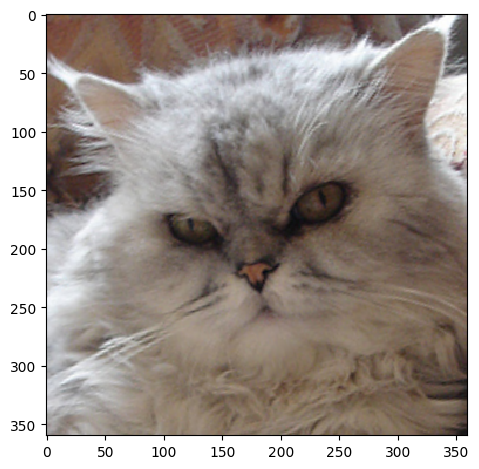

In [22]:
newim=align_and_crop_one_cat_to_destination_cat(src1_im,lm1,dis_im,lm_dis)
io.imshow(newim)

1
Shape of image is (500, 375, 3)
 data uint8


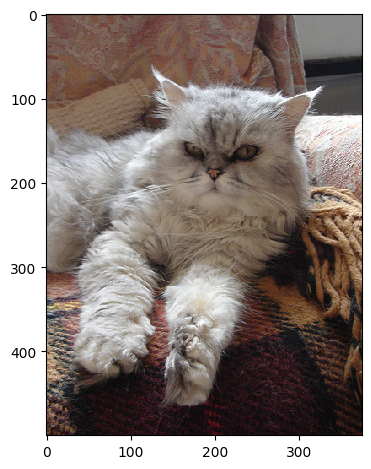

2


FileNotFoundError: [Errno 2] No such file or directory: '../data/data4/00000002_000.jpg.cat'

In [25]:
#run it on all files in the folder
for i in range(1,13):
    print(i)
    lm_dir=f"../data/data4/0000000{i}_000.jpg.cat"
    im_dir=f"../data/data4/0000000{i}_000.jpg"
    lm_dis=read_landmark_file(lm_dir)
    i=l.load_im(im_dir)

In [ ]:
def preprocess_all_cats(in_dir, out_dir):
    """
    Create aligned and cropped version of image
    :param in_dir: Where are the original photos and landmark files
    :param out_dir: Where should the preprocessed files be placed
    """
    dst = "data/ModelCat"
    dst_lm = read_landmark_file(f"{dst}.jpg.cat")
    dst_img = io.imread(f"{dst}.jpg")

    all_images = glob.glob(in_dir + "*.jpg")
    for img_idx in all_images:
        name_no_ext = os.path.splitext(img_idx)[0]
        base_name = os.path.basename(name_no_ext)
        out_name = f"{out_dir}/{base_name}_preprocessed.jpg"

        src_lm = read_landmark_file(f"{name_no_ext}.jpg.cat")
        src_img = io.imread(f"{name_no_ext}.jpg")

        proc_img = align_and_crop_one_cat_to_destination_cat(src_img, src_lm, dst_img, dst_lm)
        if proc_img is not None:
            io.imsave(out_name, proc_img)

In [10]:
def preprocess_one_cat():
    src = "data/MissingCat"
    dst = "data/ModelCat"
    out = "data/MissingCatProcessed.jpg"

    src_lm = read_landmark_file(f"{src}.jpg.cat")
    dst_lm = read_landmark_file(f"{dst}.jpg.cat")

    src_img = io.imread(f"{src}.jpg")
    dst_img = io.imread(f"{dst}.jpg")

    src_proc = align_and_crop_one_cat_to_destination_cat(src_img, src_lm, dst_img, dst_lm)
    if src_proc is None:
        return

    io.imsave(out, src_proc)

    fig, ax = plt.subplots(ncols=3, figsize=(16, 6))
    ax[0].imshow(src_img)
    ax[0].plot(src_lm[:, 0], src_lm[:, 1], '.r', markersize=12)
    ax[1].imshow(dst_img)
    ax[1].plot(dst_lm[:, 0], dst_lm[:, 1], '.r', markersize=12)
    ax[2].imshow(src_proc)
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()

In [11]:
def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out